# 트랜스포머

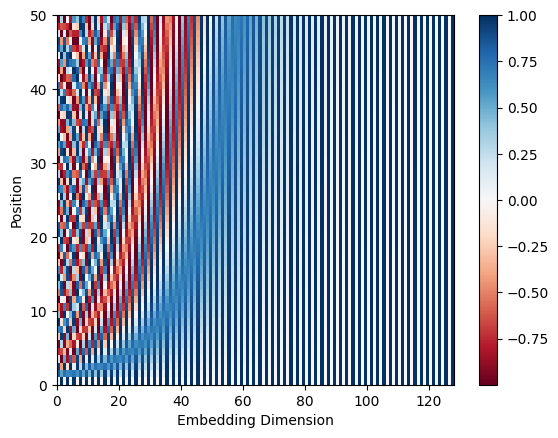

In [ ]:
#위치 인코딩
import math
import torch
from torch import nn
from matplotlib import pyplot as plt


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1): #d_model : 임베딩 차원, max_len : 최대 시퀀스
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model) #pe변수의 텐서차원은 [최대시퀀스, 1, 입력 임베딩의 차원]을 의미
        pe[:, 0, 0::2] = torch.sin(position * div_term) #인덱스가 짝수 일때 sin함수로 위치 인코딩 계산,
        pe[:, 0, 1::2] = torch.cos(position * div_term) # 홀수 일때 cos함수로 위치 인코딩 계산
        self.register_buffer("pe", pe) #모델이 매개변수를 갱신하지 ㅏㅇㄶ도록

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x) #입력 임베딩과 더해진 후 드롭아웃 적용하기


encoding = PositionalEncoding(d_model=128, max_len=50) #입력임베딩의 차원은 128이고 최대 시퀀스는 50이다.

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [ ]:
pip install torchdata torchtext portalocker

In [ ]:
!pip install torchtext==0.4

In [ ]:
# Multi30k 데이터세트가 다운로드 되지 않고, Timeout 오류가 발생하는 경우, 다음 셀을 실행한다.
from torchtext.datasets import multi30k


multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

In [ ]:
#데이터 세트 다운로드 및 전처리
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for text in text_iter:
        yield token_transform[language](text[language_index[language]])


SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"), #각각 토크나이저와 어휘사전 생성
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}
print("Token Transform:")
print(token_transform)

vocab_transform = {} #vocab transform 변수는 토큰을 인덱스로 변환시키는 함수를 저장
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
     #Multi30k 데이터세트를 활용해 (독일어, 영어)의 튜플형식으로 데이터를 불러온다. 언어별 어휘 사전을 생성한다.
    vocab_transform[language] = build_vocab_from_iterator( #생성된 토큰을 이용해 단어 집합 생성
        generate_tokens(train_iter, language),
        min_freq=1, #최소 빈도수 지정
        specials=special_symbols, #트랜스포머에 활용하는 특수 토큰을 지정
        special_first=True, #참인 경우 특수 토큰을 단어 집합의 맨 앞에 추가한다.
    )

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)  #인덱스의 기본값을 설정한다.

print("Vocab Transform:")
print(vocab_transform)

OSError: [E050] Can't find model 'de_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
#트랜스포머 모델 구성
import math
import torch
from torch import nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module): #TokenEmbedding 클래스로 소스 데이터와 입력 데이터를 입력 임베딩으로 변환하여
                                       #src_tok_emb와 tgt_tok_emb를 생성한다.
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer = nn.Transformer( #파이토치에서 제공하는 트랜스포머 클래스를 적용한다.
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size) #generator는 마지막 트랜스포머 디코더 블록에서 산출되는 벡터를 선형 변환해 어휘 사전에 로짓(logit)을 생성한다.

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer( #트랜스포머 블록은 파이토치에서 제공하는 트랜스포머 클래스를 적용한다.
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

In [ ]:
#트랜스포머 클래스
transformer=torch.nn.Transformer(
    d_model=512, #임베딩 차원
    nhead=8, #헤드의 개수
    num_encoder_layers=6, #인코더 계층 개수
    num_decoder_layers=6,
    dim_feedforward=2048, #순방향 신경망 크기, 은닉층 크기
    dropout=0.1, #드롭아웃 비율
    activation=torch.nn.functional.relu, #활성화 함수
    layer_norm_eps=1e-05, #계층 정규화 입실론
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
#트랜스포머 순방향 메서드
output=transformer.forward(
    src, #소스
    tgt, #타깃
    src_mask=None,
    tgt_mask=None,
    memory_mask=None, #메모리 마스크는 인코더 출력의 마스크로 메모리 마스크의 값이 0인 위치에서는 어텐션 연산이 수행x
    src_key_padding_mask=None, #키패딩마스크는 입력 시퀀스에서 패딩 토큰이 위치한 부분을 가리키는 이진 마스크로,,,,
    tgt_key_padding_mask=None,
    memory_key_padding_mask=None,
)

NameError: name 'src' is not defined

In [ ]:
#트랜스포머 모델 구조
from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(  #입력 임베딩, 위치 인코딩, 트랜스포머 블록, 로짓 생성으로 구성된다.
    num_encoder_layers=3, #각각 세개의 계층으로 구성된다.
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE) #교차엔트로피 함수를 적용하다. #무시되는 색인 값을 패딩 토큰을 할당해 모델이 학습하는 동안 무시해야할 클래스 레이블을 지정
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

NameError: name 'vocab_transform' is not defined

In [ ]:
#학습에 사용하려는 배치 데이터 생성
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def sequential_transforms(*transforms): #여러 개의 전처리 함수를 인자로 받아 이를 차례로 적용하는 함수를 반환하는 함수이다.
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def input_transform(token_ids): #인덱스화된 토큰에 문장의 시작 bos와 eos을 알리는 특수토큰을 할당한다.
    return torch.cat(
        (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
    )

def collator(batch): #배치 단위로 데이터를 처리한다.
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX) #패딩 시퀀스 함수를 사용해 소스와 타깃 시퀀스를 패딩한다.
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[language] = sequential_transforms(
        token_transform[language], vocab_transform[language], input_transform
    )

data_iter = Multi30k(split="valid", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

KeyError: 'de'

In [ ]:
#어텐션 마스크 생성
def generate_square_subsequent_mask(s): #마스크를 생성하는 함수
    mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1) #s x s 크기의 마스크를 생성한다.
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


def create_mask(src, tgt): #패딩 마스크를 생성하는 함수
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)

print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask.shape)
print(target_padding_mask)

In [ ]:
#모델 학습 및 평가
def run(model, optimizer, criterion, split):#run 함수는 모델 학습 및 평가를 위한 함수
    model.train() if split == "train" else model.eval()
    data_iter = Multi30k(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            trg=target_input,
            src_mask=src_mask, #어텐션 마스크
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask, #입력 패딩 마스크
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_output.reshape(-1))
        if split == "train":
            loss.backward()
            optimizer.step()
        losses += loss.item()

    return losses / len(list(dataloader))


for epoch in range(5): #
    train_loss = run(model, optimizer, criterion, "train") #학습 손실
    val_loss = run(model, optimizer, criterion, "valid") #검증 손실 모두 감소함.
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

In [ ]:
#트랜스포머 모델 번역 결과
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol): #그리드 디코딩 방식으로 번역 결과 출력
# 가장 높은 확률을 가지는 단어룰 선택하는 방법
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask) #마지막 인코더 트랜스포머 블록의 벡터를 추출한다.
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE) #타깃 데이터의 입력 텐서
    for i in range(max_len - 1):
        memory = memory.to(DEVICE) #인코더 트랜스포머 블록의 벡터
        target_mask = generate_square_subsequent_mask(ys.size(0)) #타깃 마스크
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask) #[토큰개수, 배치 크기, 확률]형태를 가진다.
        out = out.transpose(0, 1) #transpose 함수를 이용하여 [배치크기, 토큰개수, 확률] 형태로 변환한 후, 텐서를 슬라이싱해 [배치크기, 확률 형태]로 만든다.
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys


def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1] #lookup_tokens 함수를 통해 텍스트로 변환
    return " ".join(output)


output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebäude .")
print(output_oov)
print(output)

# GPT

In [ ]:
#문장 생성을 위한 GPT-2 모델의 구조
from transformers import GPT2LMHeadModel


model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path="gpt2") #불러오려는 사전 학습된 모델
# 12개의 디코더 계층을 사용하는 간소화 모델

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer
└ wte
└ wpe
└ drop
└ h
│  └ 0
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 1
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 2
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 3
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 4
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 5
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 6
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 7
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 8
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 9
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 10
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 11
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
└ ln_f
lm_head


In [ ]:
#GPT2를 이용한 문장 생성
from transformers import pipeline


generator = pipeline(task="text-generation", model="gpt2") #text-generation은 텍스트 생성 작업을 의미,
outputs = generator(
    text_inputs="Machine learning is", #입력 텍스트
    max_length=20, #최대길이로 생성될 문장의 최대 토큰 수를 제한
    num_return_sequences=3, #반환 시퀀스 개수
    pad_token_id=generator.tokenizer.eos_token_id #패딩 토큰은 모델의 자유 생성 여부를 설정한다.
    #입력된 문장의 문맥을 기반으로 자유롭게 다음 단어나 문장 생성
)
print(outputs)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': "Machine learning is all about making things more accurate. We've built an elegant and intuitive solution to this"}, {'generated_text': 'Machine learning is a technique where the participants build an algorithm to predict, assess and respond to a set'}, {'generated_text': 'Machine learning is a tricky subject. However, it is also true that many areas of programming and problem'}]


In [ ]:
pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.4 MB/s eta 0:00:00


In [ ]:
pip uninstall torch

Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/nvfuser/*
    /usr/local/lib/python3.10/dist-packages/torch-2.0.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n, 
Proceed (Y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n, 
Proceed (Y/n)? y
  Successfully uninstalled torch-2.0.1


In [ ]:
pip install torch==2.5.0

In [ ]:
!pip install torchtext==0.15.2

In [ ]:
pip install portalocker

In [ ]:
#CoLA 데이터세트 불러오기
import torch
from torchtext.datasets import CoLA
from transformers import AutoTokenizer
from torch.utils.data import DataLoader


def collator(batch, tokenizer, device): #train, dev, test로 구성된다.
    source, labels, texts = zip(*batch)
    tokenized = tokenizer(
        texts,
        padding="longest", #패딩에 인자
        truncation=True, #절사에 인자
        return_tensors="pt" #반환 형식 설정에 pt를 입력하면 파이토치 텐서 형태로 결과 반환
    )
    input_ids = tokenized["input_ids"].to(device) #토큰 ID는 토크나이저가 각 토큰에 대해 부여한 숫자 ID를 담고 있다.
    attention_mask = tokenized["attention_mask"].to(device) #어텐션 마스크는 입력 문장의 실제 단어에 대응하는 부분은 1로, 패딩에 대응하는 부분은 0으로 채운다.
    labels = torch.tensor(labels, dtype=torch.long).to(device)
    return input_ids, attention_mask, labels


train_data = list(CoLA(split="train"))
valid_data = list(CoLA(split="dev"))
test_data = list(CoLA(split="test"))

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

epochs = 3
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    collate_fn=lambda x: collator(x, tokenizer, device),
    shuffle=True,
)
valid_dataloader = DataLoader(
    valid_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)
test_dataloader = DataLoader(
    test_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)

print("Train Dataset Length :", len(train_data))
print("Valid Dataset Length :", len(valid_data))
print("Test Dataset Length :", len(test_data))

AttributeError: 'NoneType' object has no attribute 'Lock'
This exception is thrown by __iter__ of _MemoryCellIterDataPipe(remember_elements=1000, source_datapipe=_ChildDataPipe)

In [ ]:
#GPT-2 모델 설정
from torch import optim
from transformers import GPT2ForSequenceClassification #문장 분류 모델 클래스

model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2 #올바른 문장과 올바르지 않은 문장이 태깅돼 있으므로 분류 레이블 수를 2개로 함.
).to(device)
model.config.pad_token_id = model.config.eos_token_id #eos 토큰을 사용해 패딩 토큰으로 대체한다.
optimizer = optim.Adam(model.parameters(), lr=5e-5)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [ ]:
#GPT-2 모델 학습 및 검증
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss  #train 함수로 모델 학습 시 손실은 모델 출력값의 loss 속성으로 가져온다.
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader): #모델 평가
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss() #교차 엔트로피 함수로 모델을 평가한다.
        val_loss, val_accuracy = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits #모델에서 반환하는 손실값이 아닌, 로짓 값과 레이블로 손실을 계산

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids) #예측결과와 실제 레이블을 비교하여 정확도 계산

            val_loss += loss
            val_accuracy += accuracy

    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs): #각 에폭에서 학습손실, 검증 손실, 검증 정확도 계산
    train_loss = train(model, optimizer, train_dataloader) #학습 손실
    val_loss, val_accuracy = evaluation(model, valid_dataloader) #검증 손실, 검증 정확도
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/GPT2ForSequenceClassification.pt")
        print("Saved the model weights")

NameError: name 'epochs' is not defined

In [ ]:
#모델 평가
model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
model.load_state_dict(torch.load("../models/GPT2ForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader) #손실값과 정확도 평가
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

# BERT

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [59.5 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,107 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu 

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Package 'python-dev' has no installation candidate


In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
pip install korpora

In [ ]:
#네이버 영화 리뷰 데이터 불러오기
import numpy as np
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42) #20000개의 데이터세트를 6:2:2로 분리해 학습 데이터, 검증데이터, 테스트 데이터로 활용했다


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:00, 39.8MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 26.0MB/s]                           


In [ ]:
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(train.head(5).to_markdown())
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

|       | text                                                     |   label |
|------:|:---------------------------------------------------------|--------:|
| 26891 | 역시 코믹액션은 성룡, 홍금보, 원표 삼인방이 최고지!!     |       1 |
| 25024 | 점수 후하게 줘야것네 별 반개~                            |       0 |
| 11666 | 오랜만에 느낄수 있는 [감독] 구타욕구.                    |       0 |
| 40303 | 본지는 좀 됬지만 극장서 돈주고 본게 아직까지 아까운 영화 |       0 |
| 18010 | 징키스칸이란 소재를 가지고 이것밖에 못만드냐             |       0 |
Training Data Size : 12000
Validation Data Size : 4000
Testing Data Size : 4000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
#BERT 입력 텐서 생성
import torch
from transformers import BertTokenizer #BERT토크나이저 클래스로 데이터를 전처리한다.
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler #무작위 샘플러 클래스와 시퀀셜 샘플러 클래스 사용


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device) #텍스트는 숫자ID와 어텐션 마스크로 변경
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device) #레이블이 텐서 형식으로 변환
    return TensorDataset(input_ids, attention_mask, labels)


def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased", #다중 언어를 지원하며 대소문자를 유지
    do_lower_case=False #소문자로 변환하지 않겠다
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)  #무작위 샘플러 클래스와 시퀀셜 샘플러 클래스 사용

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size) #get_datalodader함수는 샘플러 클래스를 활용해 데이터를 목적에 따라 샘플링한다.

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(tensor([   101,  58466,   9812, 118956, 119122,  59095,  10892,   9434, 118888,
           117,   9992,  40032,  30005,    117,   9612,  37824,   9410,  12030,
         42337,  10739,  83491,  12508,    106,    106,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,

In [ ]:
#BERT 모델 선언
from torch import optim
from transformers import BertForSequenceClassification #BERT 문장 분류 모델 클래스 불러오기


model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    num_labels=2
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8) #AdamW 활성화 함수를 이용해 매개변수의 학습률을 조절한다,

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

bert
└ embeddings
│  └ word_embeddings
│  └ position_embeddings
│  └ token_type_embeddings
│  └ LayerNorm
│  └ dropout
└ encoder
│  └ layer
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  │  └ 6
│  │  └ 7
│  │  └ 8
│  │  └ 9
│  │  └ 10
│  │  └ 11
└ pooler
│  └ dense
│  └ activation
dropout
classifier


In [ ]:
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)

            val_loss += loss
            val_accuracy += accuracy

    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BertForSequenceClassification.pt")
        print("Saved the model weights")

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    num_labels=2
).to(device)
model.load_state_dict(torch.load("../models/BertForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

# BART

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#뉴스 요약 데이터세트 불러오기
import numpy as np
from datasets import load_dataset


news = load_dataset("argilla/news-summary", split="test")
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]] #테스트데이터 5000개 샘플링 사용
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(f"Source News : {train.text.iloc[0][:200]}")
print(f"Summarization : {train.prediction.iloc[0][:50]}")
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

(…)-00000-of-00001-ebc48879f34571f6.parquet:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

(…)-00000-of-00001-6227bd8eb10a9b50.parquet:   0%|          | 0.00/31.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20417 [00:00<?, ? examples/s]

Source News : DANANG, Vietnam (Reuters) - Russian President Vladimir Putin said on Saturday he had a normal dialogue with U.S. leader Donald Trump at a summit in Vietnam, and described Trump as civil, well-educated
Summarization : Putin says had useful interaction with Trump at Vi
Training Data Size : 3000
Validation Data Size : 1000
Testing Data Size : 1000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
#BART 입력 텐서 생성
import torch
from transformers import BartTokenizer #BART토크나이저사용
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt",
        max_length=1024
    )
    labels = []
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    for target in data.prediction: #data.prediction에 있는 텍스트를 각 문장마다 tokenizer.encode()로 토큰화하고, 각 토큰을 pad_sequence로 패딩
        labels.append(tokenizer.encode(target, return_tensors="pt").squeeze())
    labels = pad_sequence(labels, batch_first=True, padding_value=-100).to(device) #패딩값은 -100을 사용 -> 손실 함수에서 패딩된 토큰을 무시하게 하기 위해 사용
    return TensorDataset(input_ids, attention_mask, labels)



def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 8 #BART 모델이 더 긴 문장 입력을 지원하는 특성상 메모리 사용량을 고려한 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BartTokenizer.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base" #사전 학습된 모델은 페이스북,,으로
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(tensor([   0,  495, 1889,  ...,    1,    1,    1]), tensor([1, 1, 1,  ..., 0, 0, 0]), tensor([    0, 35891,   161,    56,  5616, 10405,    19,   140,    23,  5490,
         3564,     2,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100]))


In [ ]:
#모델 선언
from torch import optim
from transformers import BartForConditionalGeneration #조건부 생성 클래스-입력 시퀀스로부터 출력 시퀀스를 생성하는데 사용


model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

model
└ shared
└ encoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
└ decoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
lm_head


# BART 모델 평가

In [ ]:
!pip install evaluate rouge_score absl-py

In [ ]:
#BART 모델 학습 및 평가
import numpy as np
import evaluate


def calc_rouge(preds, labels): #calc_rouge 함수는 텍스트 요약 작업에서 모델이 예측한 요약문과 정답 요약문 사이의 루지 점수를 계산한 함수
    preds = preds.argmax(axis=-1) #argmax 메서드를 통해 각 토큰에 대해 가장 높은 확률으라진 인덱스를 선택하여 1차원 배열로 변경
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) #labels는 정답 요약문이다.

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) #특수토큰을 제외하고 토큰 인덱스를 실제 텍스트로 변환한다
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge2 = rouge_score.compute( #루지 인스턴스의 컴퓨팅 메서드로 루지 점수를 계산한다.
        predictions=decoded_preds,
        references=decoded_labels
    )
    return rouge2["rouge2"]

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_rouge = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            rouge = calc_rouge(logits, label_ids)

            val_loss += loss
            val_rouge += rouge

    val_loss = val_loss / len(dataloader)
    val_rouge = val_rouge / len(dataloader)
    return val_loss, val_rouge

rouge_score = evaluate.load("rouge", tokenizer=tokenizer)
best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Rouge {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BartForConditionalGeneration.pt")
        print("Saved the model weights")

NameError: name 'tokenizer' is not defined

In [ ]:
#BART 모델 평가
model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
model.load_state_dict(torch.load("../models/BartForConditionalGeneration.pt"))

test_loss, test_rouge_score = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test ROUGE-2 Score : {test_rouge_score:.4f}") #ROUGE-2는 0에서 1 사이의 값을 가지며 1에 가까울수록 높은 성능을 의미한다.

NameError: name 'BartForConditionalGeneration' is not defined

In [ ]:
#수치화된 평가지표로만은 잘 요약됐는지 알 수 없다 -> 문장 요약문 비교
from transformers import pipeline

summarizer = pipeline(
    task="summarization",
    model=model,
    tokenizer=tokenizer,
    max_length=54,
    device="cpu"
)

for index in range(5):
    news_text = test.text.iloc[index]
    summarization = test.prediction.iloc[index]
    predicted_summarization = summarizer(news_text)[0]["summary_text"]
    print(f"정답 요약문 : {summarization}")
    print(f"모델 요약문 : {predicted_summarization}\n")

NameError: name 'model' is not defined

# ELECTRA

In [ ]:
import numpy as np
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42)
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(train.head(5).to_markdown())
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:00, 50.3MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 14.3MB/s]                            


|       | text                                                     |   label |
|------:|:---------------------------------------------------------|--------:|
| 26891 | 역시 코믹액션은 성룡, 홍금보, 원표 삼인방이 최고지!!     |       1 |
| 25024 | 점수 후하게 줘야것네 별 반개~                            |       0 |
| 11666 | 오랜만에 느낄수 있는 [감독] 구타욕구.                    |       0 |
| 40303 | 본지는 좀 됬지만 극장서 돈주고 본게 아직까지 아까운 영화 |       0 |
| 18010 | 징키스칸이란 소재를 가지고 이것밖에 못만드냐             |       0 |
Training Data Size : 12000
Validation Data Size : 4000
Testing Data Size : 4000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
#네이버 영화 리뷰 데이터세트 전처리
import torch
from transformers import ElectraTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device)
    return TensorDataset(input_ids, attention_mask, labels)


def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = ElectraTokenizer.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator", #판별 모델만을 이용해 다운스트림 작업을 수행한다.
    do_lower_case=False,
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(tensor([    2,  6511, 14347,  4087,  4665,  4112,  2924,  4806,    16,  3809,
         4309,  4275,    16,  3201,  4376,  2891,  4139,  4212,  4007,  6557,
         4200,     5,     5,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
#KoELECTRA 모델 선언
from torch import optim
from transformers import ElectraForSequenceClassification


model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

electra
└ embeddings
│  └ word_embeddings
│  └ position_embeddings
│  └ token_type_embeddings
│  └ LayerNorm
│  └ dropout
└ encoder
│  └ layer
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  │  └ 6
│  │  └ 7
│  │  └ 8
│  │  └ 9
│  │  └ 10
│  │  └ 11
classifier
└ dense
└ activation
└ dropout
└ out_proj


In [ ]:
#모델 평가
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)

            val_loss += loss
            val_accuracy += accuracy

    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/ElectraForSequenceClassification.pt")
        print("Saved the model weights")

KeyboardInterrupt: 

In [ ]:
model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)
model.load_state_dict(torch.load("../models/ElectraForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

# T5

In [ ]:
#뉴스요약 데이터세트 불러오기
import numpy as np
from datasets import load_dataset


news = load_dataset("argilla/news-summary", split="test")
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]] #text는 뉴스본문을 의미,
df["text"] = "summarize: " + df["text"] #본문 앞에 summarize를 붙인다.
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(f"Source News : {train.text.iloc[0][:200]}")
print(f"Summarization : {train.prediction.iloc[0][:50]}")
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

(…)-00000-of-00001-ebc48879f34571f6.parquet:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

(…)-00000-of-00001-6227bd8eb10a9b50.parquet:   0%|          | 0.00/31.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20417 [00:00<?, ? examples/s]

Source News : summarize: DANANG, Vietnam (Reuters) - Russian President Vladimir Putin said on Saturday he had a normal dialogue with U.S. leader Donald Trump at a summit in Vietnam, and described Trump as civil, we
Summarization : Putin says had useful interaction with Trump at Vi
Training Data Size : 3000
Validation Data Size : 1000
Testing Data Size : 1000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# 뉴스 요약 데이터세트 전처리
import torch
from transformers import T5Tokenizer #T5 토크나이저 클래스를 불러온다.
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence


def make_dataset(data, tokenizer, device):
    source = tokenizer(
        text=data.text.tolist(),
        padding="max_length",
        max_length=128,
        pad_to_max_length=True, #패딩 방식은 최대 길이128 보다 짧으면 패딩을 수행하고 길면 문장을 자른다.
        truncation=True,
        return_tensors="pt"
    )

    target = tokenizer(
        text=data.prediction.tolist(),
        padding="max_length",
        max_length=128,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )

    source_ids = source["input_ids"].squeeze().to(device) #토큰 인덱스(input_ids)
    source_mask = source["attention_mask"].squeeze().to(device) #어텐션 마스크를 반환
    target_ids = target["input_ids"].squeeze().to(device)
    target_mask = target["attention_mask"].squeeze().to(device)
    return TensorDataset(source_ids, source_mask, target_ids, target_mask)

def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path="t5-small" #사전 학습된 모델은 t5-small로 T5의 기본 버전을 의미한다.
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(next(iter(train_dataloader)))
print(tokenizer.convert_ids_to_tokens(21603))
print(tokenizer.convert_ids_to_tokens(10))

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[tensor([[21603,    10,   309,  ..., 12529,     6,     1],
        [21603,    10,   446,  ...,     3,     7,     1],
        [21603,    10,  7934,  ...,   907,  1323,     1],
        ...,
        [21603,    10,   549,  ...,     0,     0,     0],
        [21603,    10,    27,  ...,    17,  5993,     1],
        [21603,    10,  3001,  ...,     8,  1595,     1]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([[11279, 13849,  2222,  ...,     0,     0,     0],
        [ 9995,    29, 20417,  ...,     0,     0,     0],
        [ 4726,    31,     7,  ...,     0,     0,     0],
        ...,
        [ 7819,     3, 19679,  ...,     0,     0,     0],
        [   86,  6697,    31,  ...,     0,     0,     0],
        [ 4151,  1614,  2219,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  .

In [ ]:
#T5 모델 선언
from torch import optim
from transformers import T5ForConditionalGeneration # #T5 조건부 생성 클래스
#shared 임베딩 함수는 인코더와 디코더 함수에 사용되는 토큰 임베딩으로 서로 공유되게 설정된다.

model = T5ForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="t5-small",
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

shared
encoder
└ embed_tokens
└ block
│  └ 0
│  │  └ layer
│  └ 1
│  │  └ layer
│  └ 2
│  │  └ layer
│  └ 3
│  │  └ layer
│  └ 4
│  │  └ layer
│  └ 5
│  │  └ layer
└ final_layer_norm
└ dropout
decoder
└ embed_tokens
└ block
│  └ 0
│  │  └ layer
│  └ 1
│  │  └ layer
│  └ 2
│  │  └ layer
│  └ 3
│  │  └ layer
│  └ 4
│  │  └ layer
│  └ 5
│  │  └ layer
└ final_layer_norm
└ dropout
lm_head


In [ ]:
#T5 모델 학습 및 평가
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for source_ids, source_mask, target_ids, target_mask in dataloader:
        decoder_input_ids = target_ids[:, :-1].contiguous()  #디코더에 입력될 시퀀스를 인코딩한 텐서로, 마지막 토큰을 제외한 나머지 토큰을 사용
        labels = target_ids[:, 1:].clone().detach() #다음 시점을 예측하도록 설정
        labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100 #손실값 계산시 무시되게 설정
        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            decoder_input_ids=decoder_input_ids,
            labels=labels,
        )

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss


def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss = 0.0

        for source_ids, source_mask, target_ids, target_mask in dataloader:
            decoder_input_ids = target_ids[:, :-1].contiguous()
            labels = target_ids[:, 1:].clone().detach()
            labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

            outputs = model(
                input_ids=source_ids,
                attention_mask=source_mask,
                decoder_input_ids=decoder_input_ids,
                labels=labels,
            )

            loss = outputs.loss
            val_loss += loss

    val_loss = val_loss / len(dataloader)
    return val_loss


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/T5ForConditionalGeneration.pt")
        print("Saved the model weights")

Epoch 1: Train Loss: 4.3348 Val Loss: 3.3522


RuntimeError: Parent directory ../models does not exist.

In [ ]:
#T5 생성 모델 테스트
model.eval()
with torch.no_grad():
    for source_ids, source_mask, target_ids, target_mask in test_dataloader:
        generated_ids = model.generate( #생성 메서드
            input_ids=source_ids, #토큰 인덱스
            attention_mask=source_mask, #입력문장의 인코딩과 마스킹 정보
            max_length=128, #생성될 요약문의 최대길이
            num_beams=3, #빔 개수는 빔 서치 알고리즘의 빔 크기를 의미함. 가장 높은 확률을 가진 시퀀스를 선택
                                        # 최종적으로 가장 높은 확률을 가진 시퀀스를 선택한다. 3개중에서
            repetition_penalty=2.5, #반복 패널티로 이 값이 높을 수록 중복 토큰 생성이 억제된다.
            length_penalty=1.0, #길이 패널티로 높을 수록 더욱 긴 시퀀스가 생성된다.
            early_stopping=True, #조기 중단으로최대 길이에 도달하기 전에 EOS 토큰이 생성되는 경우 중단한다.
        )

        for generated, target in zip(generated_ids, target_ids):
            pred = tokenizer.decode(
                generated, skip_special_tokens=True, clean_up_tokenization_spaces=True
            ) #특수 토큰과 불필요한 공백은 제거한다.
            actual = tokenizer.decode(
                target, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            print("Generated Headline Text:", pred)
            print("Actual Headline Text   :", actual)
        break